In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import importlib
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr
import matplotlib
import matplotlib.gridspec as gridspec 
from matplotlib.colorbar import Colorbar 

In [2]:
import numpy.ma as ma
from matplotlib.colorbar import Colorbar

In [3]:
waterMassThickness = pd.read_csv("waterMassThickness_20.csv")

In [4]:
dfmg = pd.read_csv("dfmg_corrected_DIST_IS_GL.csv")
dfgamma = pd.read_csv("gamman.csv", names=['PROFILE_NUMBER', 'gamman'])
dfmg['gamman'] = dfgamma['gamman']
del dfmg['Unnamed: 0']
dfmg.loc[:,'JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])
dfmg.loc[(dfmg['gamman'] < 0), "gamman"] = np.nan

In [5]:
dfmg["DIST_min"] = dfmg.loc[:, ["DIST_GLINE", "DIST_ISE"]].min(axis=1)

### removing the tags that recorded salinities above 35

In [6]:
sel_sal35 = (dfmg.PSAL_ADJUSTED > 35) #& (dfmg.LONGITUDE > 150)
sel_tags = dfmg.PLATFORM_NUMBER.isin(dfmg.loc[sel_sal35, "PLATFORM_NUMBER"].unique())
dfmg = dfmg.loc[~sel_tags]

In [7]:
#import plot_theta_sal
#importlib.reload(plot_theta_sal)

import plot_surfbot_vsTime as pltsurfbot
import plot_topView_contourf as topView

In [8]:
WSO_source = (dfmg['CTEMP'] <= -1.7 ) & (dfmg["PSAL_ADJUSTED"] > 34.5)
WSO_prod = (dfmg['CTEMP'] <= -0.8) & (dfmg['CTEMP'] >= -1.2) & (dfmg["PSAL_ADJUSTED"] > 34.5)

box1 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box2 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)
box3 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box4 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)

box5 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box6 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)
box7 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box8 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)

box9 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 60) & (dfmg["LONGITUDE"] < 70)
box10 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 82)

Weddell = (box1 | box2 | box3| box4)
Ross = (box5 | box6 | box7 | box8) & (dfmg.LATITUDE < -72.5)
Prydz = box10
EBS = (dfmg['LONGITUDE'] > -80) & (dfmg['LONGITUDE'] < -60) #Eastern Bellingshausen Sea
WBS = (dfmg['LONGITUDE'] > -100) & (dfmg['LONGITUDE'] < -80) # Western Bellingshausen Sea
BS = (EBS + WBS)
Adelie = (dfmg['LONGITUDE'] > 135) & (dfmg['LONGITUDE'] < 145) # Adelie Coast
Knox = (dfmg['LONGITUDE'] > 101) & (dfmg['LONGITUDE'] < 112) 
PrincessMartha = (dfmg['LONGITUDE'] > -20) & (dfmg['LONGITUDE'] < 0) & (dfmg.LATITUDE <= -65)
CDP = box9
WPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 75)
EPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 75) & (dfmg["LONGITUDE"] <= 82)
AmundsenEast = (dfmg.LONGITUDE <= -100) & (dfmg.LONGITUDE >= -110) & (dfmg.LATITUDE <= -70)
AmundsenWest = (dfmg.LONGITUDE <= -110) & (dfmg.LONGITUDE >= -120) & (dfmg.LATITUDE <= -70)
Amundsen = AmundsenEast + AmundsenWest
AS = (AmundsenEast + AmundsenWest)
LAC = (dfmg.LONGITUDE > 82) & (dfmg.LONGITUDE <= 87) & (dfmg.LATITUDE <= -65)# Leopold and Astrid Coast
QMC = (dfmg.LONGITUDE > 87) & (dfmg.LONGITUDE <= 96.5) & (dfmg.LATITUDE <= -65)# Wilhelm II Coast and Queen Mary Coast
Harald = (dfmg.LONGITUDE >= 29) & (dfmg.LONGITUDE <= 37) & (dfmg.LATITUDE <= -65)# Harald Coast

lowSurfSal = (dfmg['PSAL_ADJUSTED'] < 33.5) & (dfmg['DEPTH'] > -100)
ASW = (dfmg.CTEMP > -1.5) & (dfmg.PRES_ADJUSTED < 150) & (dfmg.POT_DENSITY < 27.4)
surfaceWaters = dfmg.PRES_ADJUSTED < 100

cdw = (dfmg['PSAL_ADJUSTED'] > 34.6) & (dfmg['CTEMP'] > 0)
maxTemp = (dfmg.groupby('PROFILE_NUMBER')['CTEMP'].transform(max) == dfmg['CTEMP'])
gline_le_50km = dfmg['DIST_min'] <= 50
gline_le_100km = dfmg['DIST_min'] <= 100
gline_le_150km = dfmg['DIST_min'] <= 150
gline_le_25km = dfmg['DIST_min'] <= 25
gline_le_75km = dfmg['DIST_min'] <= 75

sel_echodepth = dfmg.ECHODEPTH > -3000

mask_theta_sal_not_nan = ~(dfmg.loc[:, 'CTEMP'].isnull() + dfmg.loc[:, 'PSAL_ADJUSTED'].isnull())

deepMask250 = dfmg.DEPTH <= -250
deepMask375 = dfmg.DEPTH <= -375
deepMask500 = dfmg.DEPTH <= -500

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [9]:
year_mask = []
years = np.sort(dfmg['JULD'].dt.year.unique())
for i in range(len(years)):
    mask = dfmg['JULD'].dt.year == years[i]
    year_mask.append(mask)
month_mask = []
for i in range(12):
    mask = dfmg['JULD'].dt.month == i+1
    month_mask.append(mask)
    
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [10]:
def sel_months(df, months=[1]):
    return df['JULD'].dt.month.isin(months)

def get_mask_from_prof_mask(df, profmask):
    profs = dfmg.loc[profmask, 'PROFILE_NUMBER'].unique()
    mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profs)
    
    return mask

def play_beep():
    import os
    duration = 1  # second
    freq = 440  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

In [11]:
DSW = (dfmg.gamman > 28.27) & (dfmg.PSAL_ADJUSTED > 34.5) & (dfmg.CTEMP <= -1.8) & (dfmg.CTEMP >= -1.9)
lssw = (dfmg.PSAL_ADJUSTED >= 34.3) & (dfmg.PSAL_ADJUSTED <= 34.4) & (dfmg.CTEMP <= -1.5) & (dfmg.CTEMP > -1.9)
ISW = (dfmg.CTEMP < -1.9)

CDW = (dfmg.CTEMP >= 0) & (dfmg.PSAL_ADJUSTED >= 34.5)
mCDW = (dfmg.CTEMP < 0) & (dfmg.CTEMP > -1.8) & (dfmg.gamman > 28) & (dfmg.gamman < 28.27)

In [12]:
import plot_waterMassThickness as pltwmthk
importlib.reload(pltwmthk)

<module 'plot_waterMassThickness' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py'>

### How many data points exist in the vertical bins in each regions?

In [19]:
700 //20

35

In [21]:
len(np.linspace(-701, 0, 35))

35

In [13]:
A1 = gline_le_75km & sel_echodepth
A2 = ~gline_le_75km & sel_echodepth

regions = [Weddell & A1, Weddell & A2, CDP & A1, CDP & A2,   
           WPB & A1, WPB & A2,  EPB & A1, EPB & A2,
           Adelie & A1, Adelie & A2, Ross & A1, Ross & A2,
           
           PrincessMartha & A1, PrincessMartha & A2, Harald & A1, Harald & A2, 
           (LAC ) & A1, (LAC ) & A2,
           Knox & A1, Knox & A2,  AS & A1, AS & A2, 
           BS & A1, BS & A2]

titles1 = ["WS-NIS", "WS-DIS", "CD-NIS", "CD-DIS", 
           "WPB-NIS", "WPB-DIS", "EPB-NIS", "EPB-DIS",
          "AC-NIS", "AC-DIS", "RS-NIS", "RS-DIS" ] 

titles2 = ["PMC-NIS", "PMC-DIS", "PHC-NIS", "PHC-DIS",
           "LAC-NIS", "LAC-DIS", "KC-NIS", "KC-DIS",
            "AS-NIS", "AS-DIS",  "BS-NIS", "BS-DIS" ]

titles = titles1 + titles2
zbin = 20.
zlowest = -700.
column_data_count = np.zeros((2, 24, 34))
temp_mean = np.zeros((2, 24, 34))
temp_sd = np.zeros((2, 24, 34))
sal_mean = np.zeros((2, 24, 34))
sal_sd = np.zeros((2, 24, 34))
months = [[12,1,2,3,4,5], [6,7,8,9,10,11]]

for i in range(len(regions)):
    df = dfmg.loc[regions[i]]
    
    for m in range(2):
        monthmask = df.JULD.dt.month.isin(months[m]) & df.CTEMP.notnull()
        timeSlice = df.loc[monthmask]
        datalength = len(timeSlice)
        
        if datalength > 0:
            #zlowest = timeSlice.DEPTH.min() 
            number_bins = np.abs(zlowest) // zbin
            zbin_exact = np.abs(zlowest) / float(number_bins)
            depth_bins = np.linspace(zlowest-1, 0, number_bins)

            totalcount = timeSlice.groupby(pd.cut(timeSlice.DEPTH, depth_bins) ).CTEMP.count().values
            column_data_count[m, i] = totalcount
            temp_mean[m,i] = timeSlice.groupby(pd.cut(timeSlice.DEPTH, depth_bins) ).CTEMP.mean().values
            temp_sd[m,i] = timeSlice.groupby(pd.cut(timeSlice.DEPTH, depth_bins) ).CTEMP.std().values
            
            sal_mean[m,i] = timeSlice.groupby(pd.cut(timeSlice.DEPTH, depth_bins) ).PSAL_ADJUSTED.mean().values
            sal_sd[m,i] = timeSlice.groupby(pd.cut(timeSlice.DEPTH, depth_bins) ).PSAL_ADJUSTED.std().values

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/km/anaconda3/envs/pyocean35/lib/python3

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [14]:
column_data_count.shape

(2, 24, 34)

In [15]:
column_data_count = ma.masked_where(column_data_count == 0, column_data_count)

In [ ]:
from matplotlib.colors import BoundaryNorm

def plot_vertical_bin_properties(col_data, cmap="viridis", vmin=0, vmax=200, levels=[1,5,10,20,50,100,200]):
    

In [16]:
190/25.4

7.480314960629921

In [17]:
230/25.4

9.05511811023622

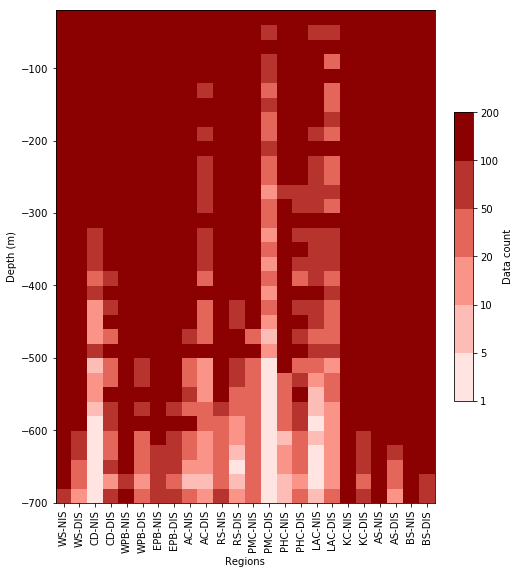

In [36]:
from matplotlib.colors import BoundaryNorm
plt.close(1)
plt.figure(1, figsize=(190/25.4, 230/25.4))
gs = gridspec.GridSpec(5, 3, width_ratios=[1, 0.05, 0.05], wspace=0)
ax = plt.subplot(gs[:, 0])
colorbar_ax = plt.subplot(gs[1:4, 2])

sel_index = 0  # 0 for summer and 1 for winter

levels = [1, 5, 10, 20, 50, 100, 200]
color_scheme = [['paleturquoise', 'deepskyblue', 'navy'], ['mistyrose', 'salmon', 'darkred']]

XX, YY = np.meshgrid(np.arange(25), np.arange(-700, 0, 20))

bnorm = BoundaryNorm(levels, ncolors=len(levels)-1, clip=False)
cmap = LinearSegmentedColormap.from_list(name='linearCmap', colors=color_scheme[1], N=len(levels)-1, ) 

PC = ax.pcolormesh(XX, YY, column_data_count[sel_index].T, vmin=min(levels), vmax= max(levels), cmap=cmap, norm=bnorm)
cbar = Colorbar(mappable = PC, ax=colorbar_ax, ticks=levels)
colorbar_ax.set_ylabel("Data count")

ax.pcolormesh(XX, YY, ma.masked_array( np.array(column_data_count[sel_index].T), 
                                      mask= ~column_data_count[sel_index].mask.T), 
                                      cmap='Greys', vmin=-1, vmax=1)

ax.set_xticks(np.arange(0.5,24.6,1))
ax.set_xticklabels(titles, rotation='vertical')
ax.set_xlim(0,24)

ax.set_ylabel("Depth (m)")
ax.set_xlabel("Regions")

plt.savefig("./Images/dataDensity/vertical_bin_density_summer.png", dpi=300)
plt.show()

In [102]:
temp_mean.shape

(2, 24, 34)

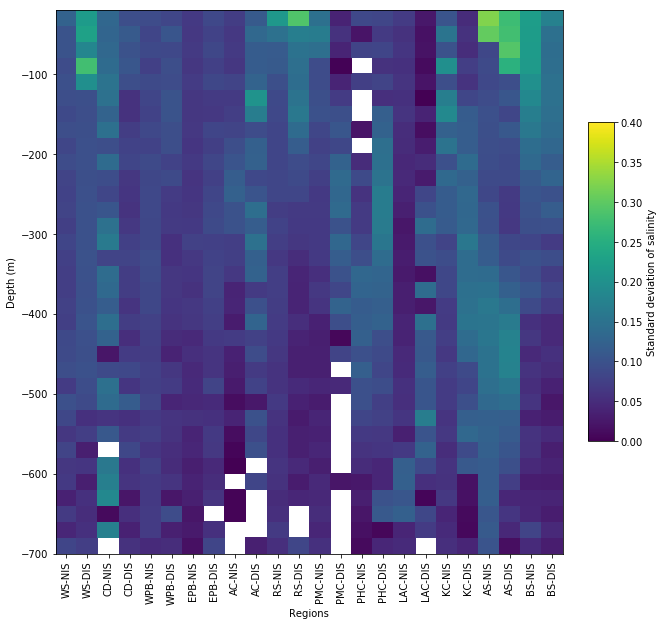

In [116]:
plt.close(1)
plt.figure(1, figsize=(10, 10))
gs = gridspec.GridSpec(5, 3, width_ratios=[1, 0.05, 0.05], wspace=0)
ax = plt.subplot(gs[:, 0])
colorbar_ax = plt.subplot(gs[1:4, 2])

plot_variable = sal_sd[1]

levels = np.arange(0, 0.5, 0.1)
XX, YY = np.meshgrid(np.arange(25), np.arange(-700, 0, 20))

PC = ax.pcolormesh(XX, YY, plot_variable.T, vmin=min(levels), vmax= max(levels), cmap='viridis')
cbar = Colorbar(mappable = PC, ax=colorbar_ax, )
colorbar_ax.set_ylabel("Standard deviation of salinity")

ax.set_xticks(np.arange(0.5,24.6,1))
ax.set_xticklabels(titles, rotation='vertical')
ax.set_xlim(0,24)

ax.set_ylabel("Depth (m)")
ax.set_xlabel("Regions")

plt.savefig("./Images/surf_bot_prop/vertical_bin_salinity_sd_winter.png", dpi=300)
plt.show()

In [9]:
!mkdir ./Images/waterMassBudgets2

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

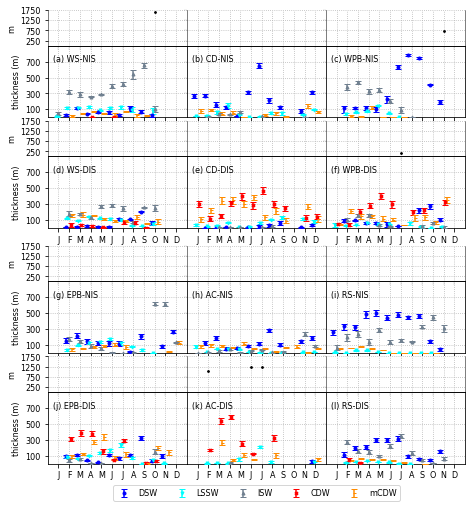

In [48]:
A1 = gline_le_75km & sel_echodepth
A2 = ~gline_le_75km & sel_echodepth

regions1 = [Weddell & A1, CDP & A1,    WPB & A1,   
            Weddell & A2, CDP & A2,    WPB & A2,   
            EPB & A1,     Adelie & A1, Ross & A1, 
            EPB & A2,     Adelie & A2, Ross & A2]

titles1 = ["(a) WS-NIS", "(b) CD-NIS", "(c) WPB-NIS",        
          "(d) WS-DIS", "(e) CD-DIS", "(f) WPB-DIS", 
          "(g) EPB-NIS","(h) AC-NIS", "(i) RS-NIS",
          "(j) EPB-DIS","(k) AC-DIS", "(l) RS-DIS" ] 

yticks = list(np.arange(100, 820, 200))
yticks_dod = list(np.arange(250,2000,500))
wmThk1_20 = pltwmthk.plot_array_waterMassThickness(dfmg,
            regions1, titles1, ht=9, save=True, ymax=900,
            savename="./Images/waterMassBudgets2/array1_20.pdf", 
            yticks=yticks, zbin=20.0, plotter=2,
            retValue=True, yticks_dod=yticks_dod, ymax_dod=None)

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = n

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = n

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:84: RuntimeWarning: invalid value encountered in true_divide
  DSWthickness[i] = np.nansum((DSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:86: RuntimeWarning: invalid value encountered in true_divide
  lsswthickness[i] = np.nansum((LSSWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:88: RuntimeWarning: invalid value encountered in true_divide
  ISWthickness[i] = np.nansum((ISWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:90: RuntimeWarning: invalid value encountered in true_divide
  CDWthickness[i] = np.nansum((CDWcount / totalcount) * zbin_exact)
/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_waterMassThickness.py:92: RuntimeWarning: invalid value encountered in true_divide
  mCDW

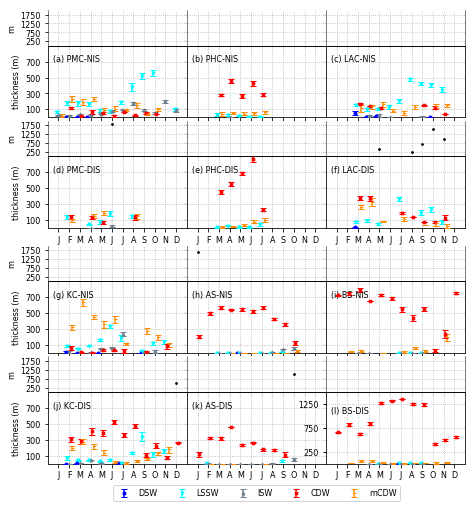

In [49]:
regions2 = [PrincessMartha & A1, Harald & A1, (LAC ) & A1,
            PrincessMartha & A2, Harald & A2, (LAC ) & A2,
            Knox & A1,  AS & A1, BS & A1, 
            Knox & A2, AS & A2, BS & A2]

titles2 = ["(a) PMC-NIS", "(b) PHC-NIS", "(c) LAC-NIS", 
           "(d) PMC-DIS", "(e) PHC-DIS", "(f) LAC-DIS",
           "(g) KC-NIS", "(h) AS-NIS", "(i) BS-NIS", 
           "(j) KC-DIS", "(k) AS-DIS", "(l) BS-DIS"]

yticks = list(np.arange(100, 820, 200)) 
yticks_dod = list(np.arange(250,2000,500))
wmThk2_20 = pltwmthk.plot_array_waterMassThickness(dfmg, 
            regions2, titles2, ht=9, save=True, ymax=900, retValue = True, zbin=20.0, plotter=2,
            savename="./Images/waterMassBudgets2/array2_20.pdf", yticks=yticks, 
            yticks_dod=yticks_dod, ymax_dod=2000)

In [50]:
DSWthickness12 = np.append(wmThk1_20[0].ravel(), wmThk2_20[0].ravel())
DSW_CI_12 = list(np.array((list(wmThk1_20[1]) + list(wmThk2_20[1]) )).reshape(288,2))

ISWthickness12 = np.append(wmThk1_20[4].ravel(), wmThk2_20[4].ravel())
ISW_CI_12 = list(np.array(list(wmThk1_20[5]) + list(wmThk2_20[5]) ).reshape(288,2))

lsswthickness12 = np.append(wmThk1_20[2].ravel(), wmThk2_20[2].ravel())
lssw_CI_12 = list(np.array(list(wmThk1_20[3]) + list(wmThk2_20[3]) ).reshape(288,2))

CDWthickness12 = np.append(wmThk1_20[8].ravel(), wmThk2_20[8].ravel())
CDW_CI_12 = list(np.array(list(wmThk1_20[9]) + list(wmThk2_20[9]) ).reshape(288,2))

mCDWthickness12 = np.append(wmThk1_20[6].ravel(), wmThk2_20[6].ravel())
mCDW_CI_12 = list(np.array(list(wmThk1_20[7]) + list(wmThk2_20[7]) ).reshape(288,2))

zlowest12 = np.append(wmThk1_20[-1].ravel(), wmThk2_20[-1].ravel())

titles = []
for t in titles1:
    titles.append([t.split()[1] ]*12)
for t in titles2:
    titles.append([t.split()[1] ]*12)

ind = np.arange(len(DSWthickness12))
waterMassThickness_20 = pd.DataFrame({'DSW':pd.Series(DSWthickness12, index=ind),
                                   'DSW_CI':pd.Series(DSW_CI_12, index=ind),
                                   'ISW':pd.Series(ISWthickness12, index=ind),
                                   'ISW_CI':pd.Series(ISW_CI_12, index=ind),
                                   'LSSW':pd.Series(lsswthickness12, index=ind),
                                   'LSSW_CI':pd.Series(lssw_CI_12, index=ind),
                                   'mCDW':pd.Series(mCDWthickness12, index=ind),
                                   'mCDW_CI':pd.Series(mCDW_CI_12, index=ind),
                                   'CDW':pd.Series(CDWthickness12, index=ind),
                                   'CDW_CI':pd.Series(CDW_CI_12, index=ind),
                                   'zlowest':pd.Series(zlowest12, index=ind),
                                   'month':pd.Series(list(np.arange(1,13,1))*24, index=ind),
                                   'region': pd.Series(np.array(titles).ravel(), index=ind)
                                  })

In [109]:
waterMassThickness_20[waterMassThickness_20.DSW.notnull()]

,DSW,DSW_CI,ISW,ISW_CI,LSSW,LSSW_CI,mCDW,mCDW_CI,CDW,CDW_CI,zlowest,month,region
0,0.000000,"[0.0, 0.0]",49.080940,"[28.88888888888889, 28.88888888888889]",12.814236,"[5.333333333333332, 5.333333333333333]",0.000000,"[0.0, 0.0]",0.000000,"[0.0, 0.0]",174.080182,1,WS-NIS
1,29.352642,"[16.808521081047576, 17.417383764179807]",320.806854,"[294.7850770149998, 299.8499189129772]",116.065214,"[102.16000546457524, 104.42111143722232]",15.850071,"[7.554391891375864, 7.70452435094973]",0.000000,"[0.0, 0.0]",743.767663,2,WS-NIS
2,111.532773,"[100.63939562918337, 102.32894943532455]",286.161296,"[261.11706344151713, 266.4379989139738]",117.435818,"[112.00011071828125, 112.41060729360863]",46.575779,"[41.60037339225578, 41.97728966079387]",0.000000,"[0.0, 0.0]",789.487368,3,WS-NIS
3,43.022989,"[37.37573469824486, 38.42935268140488]",259.743076,"[251.50033788330998, 252.35030070019718]",128.054423,"[124.38923579229095, 124.45290088743604]",71.933670,"[65.98438743320634, 68.1488470372241]",0.432062,"[0.0, 0.0]",701.031037,4,WS-NIS
4,58.774146,"[52.87280750887763, 53.620144328899336]",277.702173,"[268.63632700898796, 269.66063485997114]",102.001893,"[98.06666168683662, 98.14350671518429]",53.855091,"[50.410001135618096, 51.23629354530207]",0.000000,"[0.0, 0.0]",683.309833,5,WS-NIS
5,61.147270,"[46.202542465643766, 46.329541567114134]",367.549528,"[341.13256041144757, 341.54839366650293]",130.547257,"[122.41559317492246, 122.46294997723341]",53.691154,"[35.90322559379378, 37.680434912869316]",0.081953,"[0.0, 0.0]",752.002669,6,WS-NIS
6,26.778372,"[19.444847678027976, 19.706557082444718]",419.334746,"[390.7296747091916, 390.77678835749174]",121.304903,"[104.6220761972429, 105.66922805643296]",71.675346,"[61.51791282424472, 64.3325979935379]",0.000000,"[0.0, 0.0]",742.667936,7,WS-NIS
7,114.267807,"[84.99666986807229, 86.61528552071235]",540.230417,"[487.75545230594275, 490.8147052106599]",95.759185,"[72.31765187691714, 74.11077496724143]",21.578710,"[6.5553846153846145, 7.1984615384615385]",0.000000,"[0.0, 0.0]",836.952366,8,WS-NIS
8,68.741737,"[56.00812452514418, 56.704731257125125]",653.640713,"[625.7639902563682, 629.7317669737544]",0.000000,"[0.0, 0.0]",20.093528,"[7.315051282051281, 8.569051282051284]",0.000000,"[0.0, 0.0]",824.740954,9,WS-NIS
9,24.689670,"[3.415833333333333, 6.550833333333332]",102.063597,"[61.74916666666666, 64.88416666666664]",82.039691,"[39.94480952380952, 50.5142380952381]",0.000000,"[0.0, 0.0]",0.000000,"[0.0, 0.0]",387.841667,10,WS-NIS


In [13]:
## Plays a beep sound. Useful to notify once any script is done running
def play_beep():
    import os
    duration = 1  # second
    freq = 440  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))
play_beep()

In [14]:
waterMassThickness_20.columns

Index(['DSW', 'DSW_CI', 'ISW', 'ISW_CI', 'LSSW', 'LSSW_CI', 'mCDW', 'mCDW_CI',
       'CDW', 'CDW_CI', 'zlowest', 'month', 'region'],
      dtype='object')

### Next we compute the conditional probabilities of the presence of DSW (CDW) water masses conditional on the absence of CDW (DSW) water masses

$P(DSW\, |\, noCDW) = \frac{P(DSW\, \cap\, noCDW)}{P(noCDW)}$

In [22]:
import compute_waterMassProbabilities as wmprob
importlib.reload(wmprob)

<module 'compute_waterMassProbabilities' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/compute_waterMassProbabilities.py'>

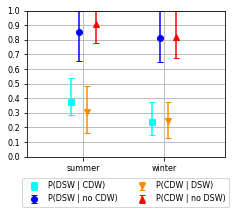

 P(DSW | CDW)= [0.37333333 0.23529412] [[0.28205128 0.53968254]
 [0.14705882 0.37735849]] 
 P(DSW | no CDW)= [0.85365854 0.81034483] [[0.65384615 1.        ]
 [0.65079365 1.        ]] 
 P(CDW | DSW)= [0.30232558 0.24074074] [[0.16326531 0.48487013]
 [0.12727273 0.375     ]] 
 P(CDW | no DSW)= [0.91176471 0.82089552] [[0.77777778 1.        ]
 [0.675      1.        ]]


In [23]:
prob_DSW_cond_noCDW, prob_DSW_cond_noCDW_CI, \
              prob_DSW_cond_noCDW_yerr = wmprob.compute_prob_unweighted_bootstrapped(waterMassThickness_20, 
                                            save=True, 
                                            savename="./Images/waterMassBudgets2/wmprobUnweighted_20_bootstrapped.pdf")

### If we look at only NIS regions, the differences are bigger, but the fewer data points result in more error

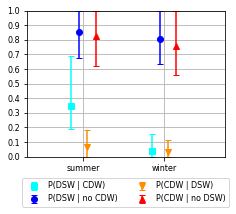

 P(DSW | CDW)= [0.34615385 0.03846154] [[0.19047619 0.6875    ]
 [0.         0.15384615]] 
 P(DSW | no CDW)= [0.85714286 0.80487805] [[0.675      1.        ]
 [0.63636364 1.        ]] 
 P(CDW | DSW)= [0.06896552 0.03225806] [[0.         0.18181818]
 [0.         0.11111111]] 
 P(CDW | no DSW)= [0.82758621 0.75757576] [[0.61764706 1.        ]
 [0.55813953 1.        ]]


In [24]:
wmsel = waterMassThickness_20.region.str.contains("NIS")
prob_DSW_cond_noCDW, prob_DSW_cond_noCDW_CI, \
              prob_DSW_cond_noCDW_yerr = wmprob.compute_prob_unweighted_bootstrapped(waterMassThickness_20[wmsel], 
                                            save=True, 
                                        savename="./Images/waterMassBudgets2/wmprobUnweighted_20_bootstrapped_NIS.pdf")

In [13]:
from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, round(p,4), lo, hi, [lo,hi]

In [14]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df, alpha=0.05, retValue="r"):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    rvalues = dfcols.transpose().join(dfcols, how='outer')
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    CI_lo = dfcols.transpose().join(dfcols, how='outer')
    CI_hi = dfcols.transpose().join(dfcols, how='outer')
    CI = dfcols.transpose().join(dfcols, how='outer')
    
    for r in df.columns:
        for c in df.columns:
            rvalues[r][c], pvalues[r][c], CI_lo[r][c], CI_hi[r][c], CI[r][c] = pearsonr_ci(df[r], df[c], alpha=alpha)
            #1-round(pearsonr(df[r], df[c])[1], 4)
    try:
        if retValue == "r":
            return rvalues
        if(retValue == "p"):
            return pvalues
        if(retValue == "lo"):
            return CI_lo
        if(retValue == "hi"):
            return CI_hi
        if(retValue == "CI"):
            return CI
    except:
        raise ValueError('retValue should be one of r,p,lo,hi')

In [122]:
calculate_pvalues(waterMassThickness_20.dropna().groupby("region").mean(), retValue="r")

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in arctanh


,DSW,ISW,LSSW,mCDW,CDW,zlowest,month
DSW,1,0.572127,-0.270218,-0.294346,-0.498902,-0.205161,0.17459
ISW,0.572127,1,-0.0354937,-0.210424,-0.537217,-0.11224,0.0163097
LSSW,-0.270218,-0.0354937,1,0.499283,-0.396355,-0.283258,0.377021
mCDW,-0.294346,-0.210424,0.499283,1,-0.231334,0.0929051,0.1887
CDW,-0.498902,-0.537217,-0.396355,-0.231334,1,0.679647,-0.172782
zlowest,-0.205161,-0.11224,-0.283258,0.0929051,0.679647,1,-0.0651625
month,0.17459,0.0163097,0.377021,0.1887,-0.172782,-0.0651625,1


In [123]:
calculate_pvalues(waterMassThickness_20.dropna().groupby("region").mean(), retValue="CI")

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in arctanh


,DSW,ISW,LSSW,mCDW,CDW,zlowest,month
DSW,"[1.0, 1.0]","[0.21935655169525192, 0.7925969937375013]","[-0.6074042054241917, 0.1494724292832295]","[-0.6236872937901093, 0.12374369271037598]","[-0.7511295184942274, -0.11956868468906362]","[-0.5620421503606698, 0.21612256686468936]","[-0.24614275171421196, 0.5399576292572029]"
ISW,"[0.21935655169525192, 0.7925969937375013]","[1.0, 1.0]","[-0.4326950875085987, 0.37324715330665065]","[-0.5657938965020893, 0.2108721808391486]","[-0.7730789049732729, -0.17084487800713566]","[-0.4933011928947732, 0.304964896356114]","[-0.3896506069405881, 0.4169631156570024]"
LSSW,"[-0.6074042054241917, 0.1494724292832295]","[-0.4326950875085987, 0.37324715330665065]","[1.0, 1.0]","[0.12006959498405693, 0.7513509125872231]","[-0.689507783181946, 0.008381375780182608]","[-0.6162399473928404, 0.1356372061349629]","[-0.031107164004069494, 0.6773933242233501]"
mCDW,"[-0.6236872937901093, 0.12374369271037598]","[-0.5657938965020893, 0.2108721808391486]","[0.12006959498405693, 0.7513509125872231]","[1.0, 1.0]","[-0.5805537967481093, 0.18977212032997037]","[-0.3225812151319994, 0.4783734845201069]","[-0.23238647860932546, 0.5502136708342484]"
CDW,"[-0.7511295184942274, -0.11956868468906362]","[-0.7730789049732729, -0.17084487800713566]","[-0.689507783181946, 0.008381375780182608]","[-0.5805537967481093, 0.18977212032997037]","[1.0, 1.0]","[0.38059735739186845, 0.8500010013334374]","[-0.5386357070086528, 0.24789308056870699]"
zlowest,"[-0.5620421503606698, 0.21612256686468936]","[-0.4933011928947732, 0.304964896356114]","[-0.6162399473928404, 0.1356372061349629]","[-0.3225812151319994, 0.4783734845201069]","[0.38059735739186845, 0.8500010013334374]","[1.0, 1.0]","[-0.45655798135558345, 0.3473651582102184]"
month,"[-0.24614275171421196, 0.5399576292572029]","[-0.3896506069405881, 0.4169631156570024]","[-0.031107164004069494, 0.6773933242233501]","[-0.23238647860932546, 0.5502136708342484]","[-0.5386357070086528, 0.24789308056870699]","[-0.45655798135558345, 0.3473651582102184]","[1.0, 1.0]"


In [25]:
waterMassThickness_20.to_csv("waterMassThickness_20.csv")

In [17]:
waterMassThickness_20 = pd.read_csv("waterMassThickness_20.csv")

In [21]:
del(waterMassThickness_20['Unnamed: 0'])

In [22]:
waterMassThickness_20.columns

Index(['DSW', 'DSW_CI', 'ISW', 'ISW_CI', 'LSSW', 'LSSW_CI', 'mCDW', 'mCDW_CI',
       'CDW', 'CDW_CI', 'zlowest', 'month', 'region'],
      dtype='object')

In [26]:
waterMassThickness_20.region.unique()

array(['WS-NIS', 'CD-NIS', 'WPB-NIS', 'WS-DIS', 'CD-DIS', 'WPB-DIS',
       'EPB-NIS', 'AC-NIS', 'RS-NIS', 'EPB-DIS', 'AC-DIS', 'RS-DIS',
       'PMC-NIS', 'PHC-NIS', 'LAC-NIS', 'PMC-DIS', 'PHC-DIS', 'LAC-DIS',
       'KC-NIS', 'AS-NIS', 'BS-NIS', 'KC-DIS', 'AS-DIS', 'BS-DIS'],
      dtype=object)

In [52]:
def find_mean_monthlyMean(wmthk, wmtype="mCDW", region="LAC-NIS"):
        selMask = (wmthk.region == region)
        wmErr = np.zeros((12, 2))
        
        wmErr[:, 0] = np.abs(np.stack(wmthk.loc[selMask, wmtype+"_CI"].values)[:, 0] - wmthk.loc[selMask, wmtype])
        wmErr[:, 1] = np.abs(np.stack(wmthk.loc[selMask, wmtype+"_CI"].values)[:, 1] - wmthk.loc[selMask, wmtype])
        
        maxErr = np.max(wmErr, axis=1)
        wmvaluesMean = np.nanmean(wmthk.loc[selMask, wmtype])
        print(np.sqrt(np.nanmean(maxErr**2)), wmvaluesMean)
        

In [55]:
find_mean_monthlyMean(waterMassThickness_20, region="KC-NIS", wmtype="mCDW")

37.02951025203417 321.5146694519674


In [37]:
bathy = xr.open_dataset("/media/data/Datasets/Bathymetry/GEBCO_2014_2D.nc")

In [38]:
bathy

<xarray.Dataset>
Dimensions:    (lat: 21600, lon: 43200)
Coordinates:
  * lat        (lat) float64 -90.0 -89.99 -89.98 -89.97 ... 89.98 89.99 90.0
  * lon        (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    elevation  (lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2014 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The bathymetric portion of the GEBCO_2014 Grid was largely ...
    history:      This is version 20150318 of the data set. Information on th...
    references:   Information on the data set is available from the GEBCO pro...
    comment:      The data in the GEBCO_2014 Grid should not be used for navi...
    node_offset:  1

In [40]:
bathy.source

'The bathymetric portion of the GEBCO_2014 Grid was largely developed from a database of ship track soundings with interpolation between soundings guided by satellite-derived gravity data. In areas where they improve on this existing base grid, data sets developed by other methods are included. Recognising the importance of local expertise when building a global bathymetric model, GEBCO have been working with regional mapping groups to improve the existing GEBCO grid. Details about the development of the grid and the data sets included can be found in the documentation that accompanies the data set. With the exception of polar regions, land data are based on the 1-km averages of topography derived from version 2.0 of the US Geological Survey SRTM30 gridded digital elevation model data product, created with data from the US National Aeronautics and Space Administration (NASA) Shuttle Radar Topography Mission. For the Arctic region north of 64N the GEBCO grid is based on the Internationa

In [8]:
selWM = waterMassThickness.region.str.contains("NIS")
waterMassThickness[selWM].groupby("region").mean().sort_values("mCDW")["mCDW"]

region
AS-NIS       3.179069
WPB-NIS     15.167198
RS-NIS      26.442711
BS-NIS      27.733130
WS-NIS      35.525335
PHC-NIS     48.830544
CD-NIS      52.012547
EPB-NIS     54.002811
AC-NIS      65.847780
PMC-NIS    105.271060
LAC-NIS    107.715718
KC-NIS     321.514669
Name: mCDW, dtype: float64